<a href="https://colab.research.google.com/github/BeagleTamer100/256/blob/main/StatsModel_Corona_moi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 8.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from statsforecast.models import AutoETS
from statsforecast.core import StatsForecast
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mase, mae, rmse
from typing import List
from functools import partial

from statsforecast.models import (
    HoltWinters,
    AutoTheta,
    CrostonClassic,
    SeasonalNaive,
    ADIDA,
    CrostonOptimized,
    CrostonSBA,
    IMAPA,
    TSB
)


In [ ]:
df = pd.read_csv('Customer Order Quantity_Dispatched Quantity_cleaned.csv')
df.head()

,date_rev,Product ID,Product Name,Date,Customer Order Quantity,Dispatched Quantity,Year,Month,Day,first_week_day
0,2/1/22,000161032,Material_4,01.02.2022,2,4,2022,2,1,1/31/22
1,2/1/23,000161032,Material_4,01.02.2023,60,68,2023,2,1,1/30/23
2,2/1/24,000161032,Material_4,01.02.2024,20,23,2024,2,1,1/29/24
3,3/1/22,000161032,Material_4,01.03.2022,53,0,2022,3,1,2/28/22
4,3/1/23,000161032,Material_4,01.03.2023,99,33,2023,3,1,2/27/23


In [ ]:
weekly_df = df.groupby(['first_week_day', 'Product Name'])['Customer Order Quantity'].sum().reset_index()
weekly_df.head()

,first_week_day,Product Name,Customer Order Quantity
0,1/1/24,Material_1,252
1,1/1/24,Material_10,251
2,1/1/24,Material_11,120
3,1/1/24,Material_12,2
4,1/1/24,Material_13,96


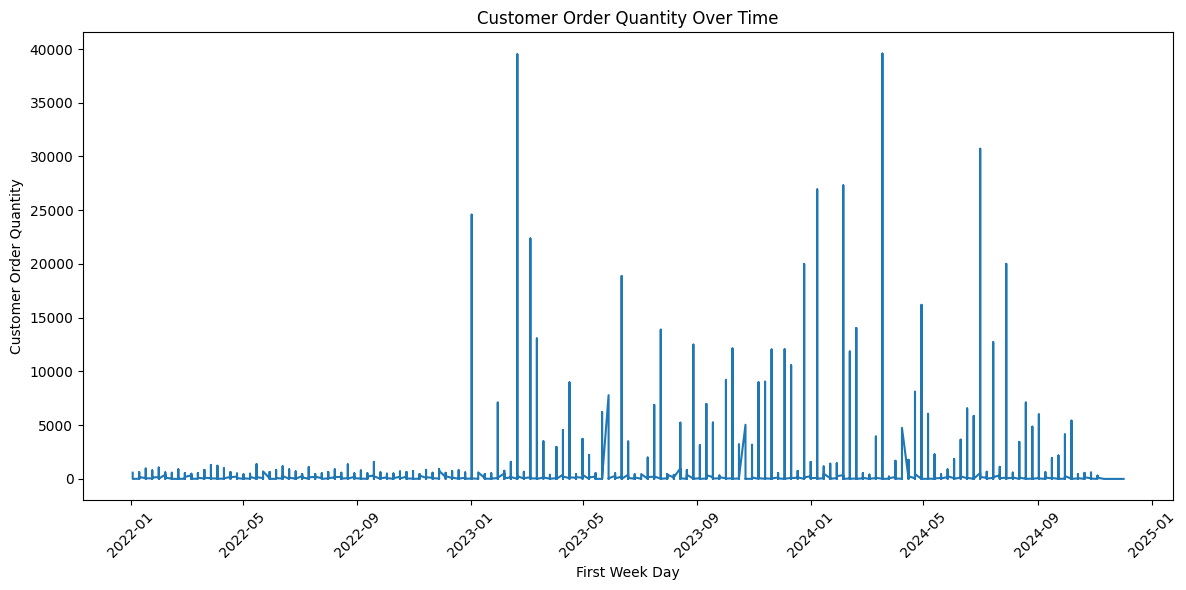

In [ ]:
# prompt: Using dataframe weekly_df: plot the table with customer order quantity on y-axis, and first_week_day as x-axis in periodic order

import pandas as pd
import matplotlib.pyplot as plt

# Convert 'first_week_day' to datetime objects
weekly_df['first_week_day'] = pd.to_datetime(weekly_df['first_week_day'])

# Sort the DataFrame by 'first_week_day'
weekly_df = weekly_df.sort_values('first_week_day')

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_df['first_week_day'], weekly_df['Customer Order Quantity'])
plt.xlabel('First Week Day')
plt.ylabel('Customer Order Quantity')
plt.title('Customer Order Quantity Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


## Modeling

In [ ]:
weekly_df.columns = ["ds", "unique_id", "y"]
weekly_df["ds"] = pd.to_datetime(weekly_df["ds"])

In [ ]:
weekly_df.head()

,ds,unique_id,y
0,2024-01-01,Material_1,252
1,2024-01-01,Material_10,251
2,2024-01-01,Material_11,120
3,2024-01-01,Material_12,2
4,2024-01-01,Material_13,96


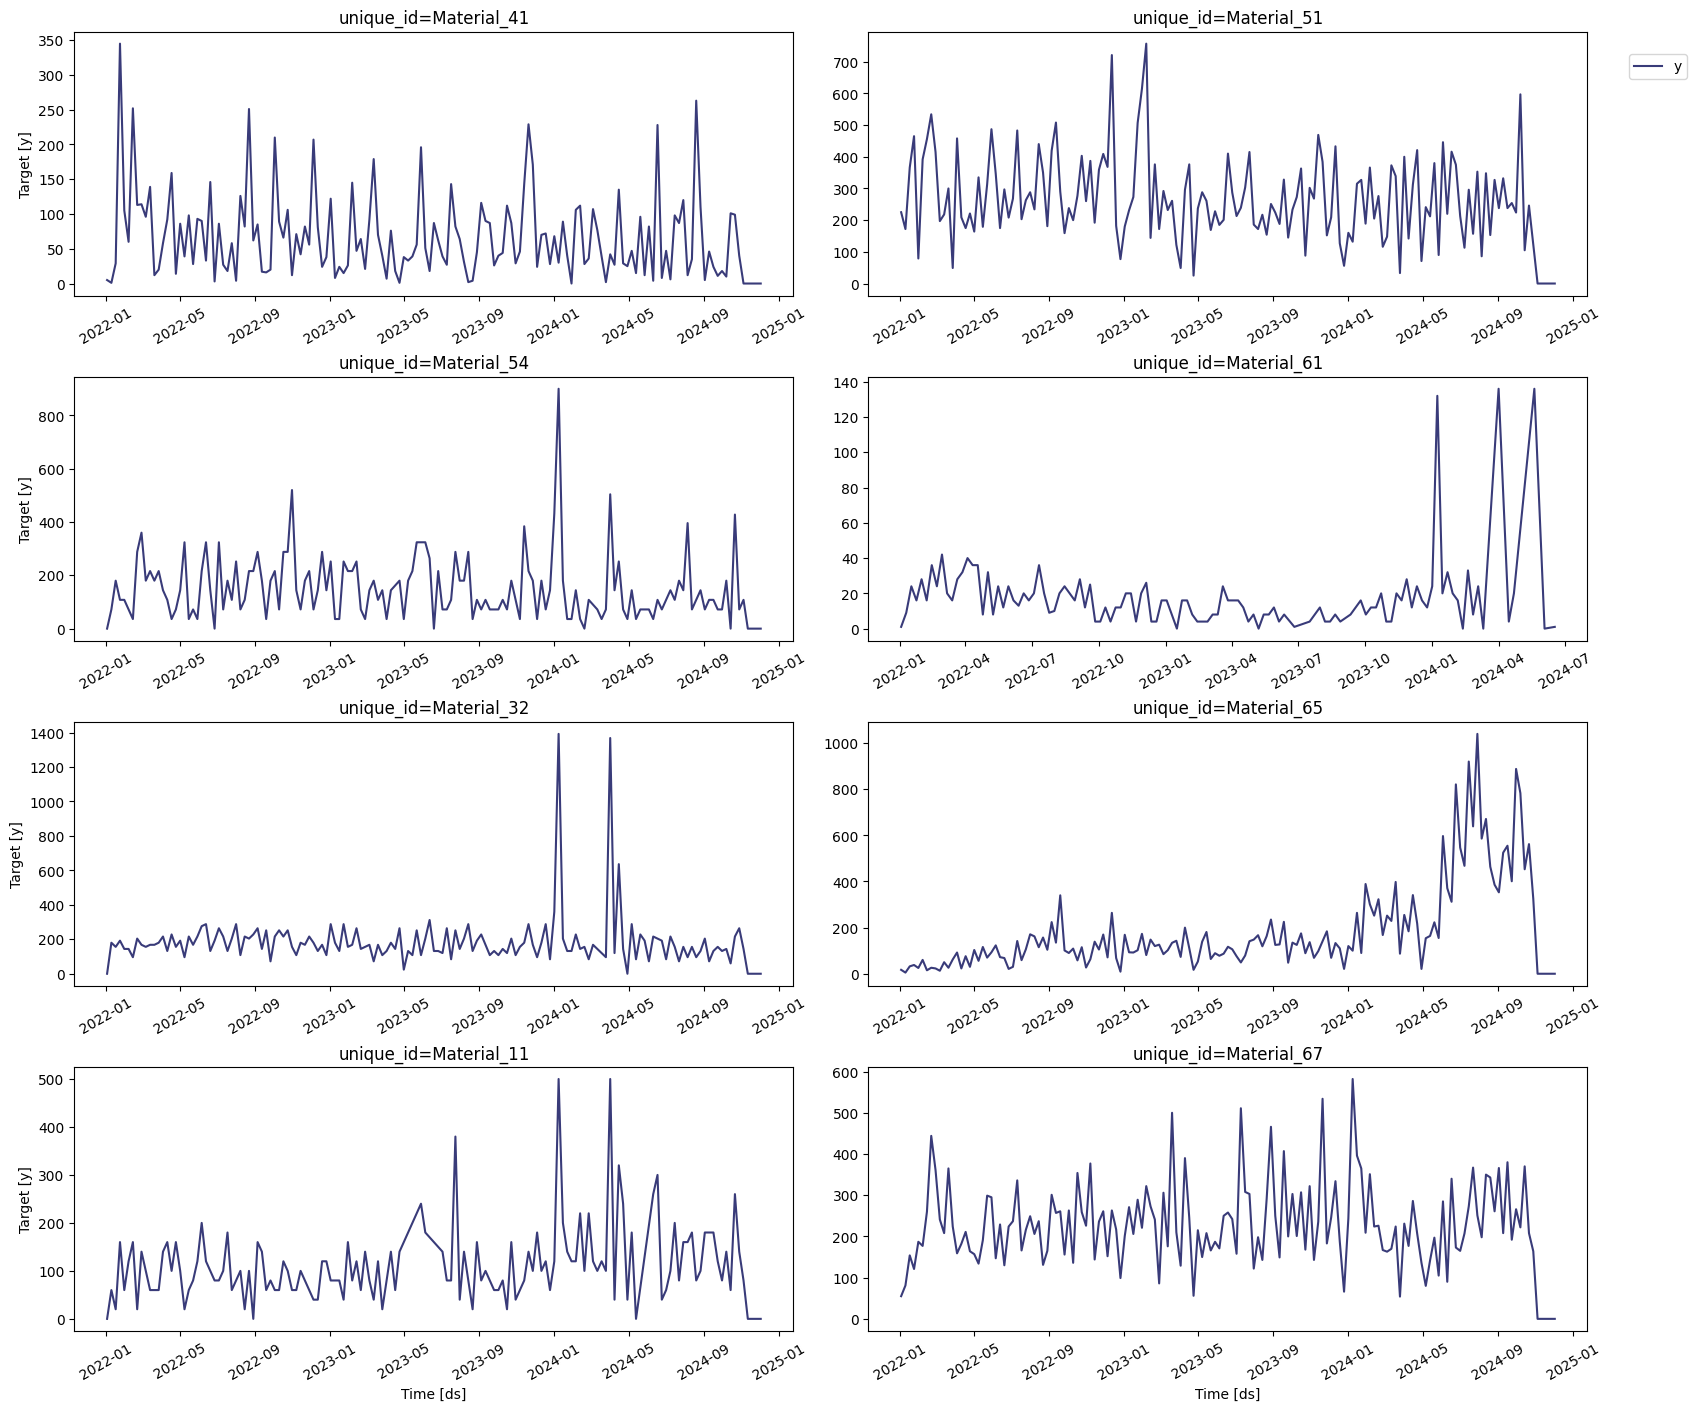

In [ ]:
StatsForecast.plot(weekly_df)

# Training / Test split

In [ ]:
train = weekly_df[weekly_df.ds<='2024-06-30']
test = weekly_df[weekly_df.ds>'2024-06-30']

In [ ]:
train.shape, test.shape

((9276, 3), (1709, 3))

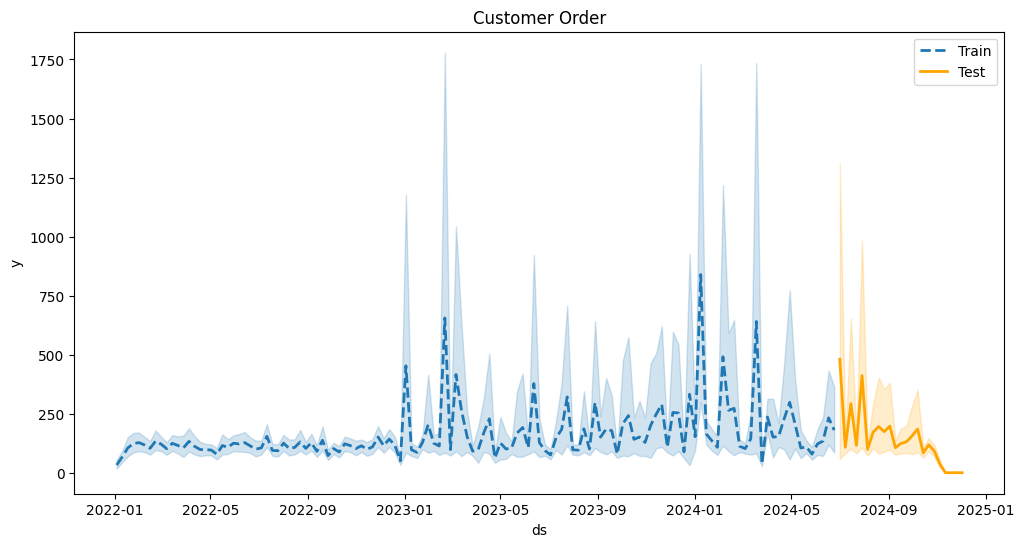

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(train,x="ds", y="y", label="Train", linestyle="--",linewidth=2)
sns.lineplot(test, x="ds", y="y", label="Test", linewidth=2, color="orange")
plt.title("Customer Order");
plt.show()

# Model

In [ ]:
# Define forecast settings
season_length = 24  # Weekly seasonality (assumes 2 years of seasonality for weekly data)
horizon = len(test['ds'].unique())  # Number of weeks to predict
freq = "W-MON"  # Weekly frequency (Monday start)

In [ ]:
def moving_average_forecast(df, window=4, horizon=4):
    """
    Computes Moving Average forecast.
    """
    forecasts = []
    for uid in df["unique_id"].unique():
        series = df[df["unique_id"] == uid].sort_values("ds")
        past_values = series["y"].rolling(window=window).mean().iloc[-1] if len(series) >= window else series["y"].mean()
        future_dates = pd.date_range(start=series["ds"].max(), periods=horizon + 1, freq="W-MON")[1:]
        forecast_df = pd.DataFrame({"unique_id": uid, "ds": future_dates, "moving_avg_forecast": [past_values] * horizon})
        forecasts.append(forecast_df)
    return pd.concat(forecasts, ignore_index=True)

def weighted_moving_average_forecast(df, window=4, horizon=4):
    """
    Computes Weighted Moving Average (WMA) forecast.
    """
    forecasts = []
    weights = np.arange(1, window + 1) / sum(np.arange(1, window + 1))  # Linearly increasing weights
    for uid in df["unique_id"].unique():
        series = df[df["unique_id"] == uid].sort_values("ds")
        if len(series) >= window:
            past_values = np.dot(series["y"].iloc[-window:], weights)
        else:
            past_values = series["y"].mean()
        future_dates = pd.date_range(start=series["ds"].max(), periods=horizon + 1, freq="W-MON")[1:]
        forecast_df = pd.DataFrame({"unique_id": uid, "ds": future_dates, "wma_forecast": [past_values] * horizon})
        forecasts.append(forecast_df)
    return pd.concat(forecasts, ignore_index=True)

def exponential_smoothing_forecast(df, alpha=0.3, horizon=4):
    """
    Computes Simple Exponential Smoothing (SES) forecast.
    """
    forecasts = []
    for uid in df["unique_id"].unique():
        series = df[df["unique_id"] == uid].sort_values("ds")["y"]
        if len(series) > 1:
            ses_value = series.iloc[0]
            for val in series:
                ses_value = alpha * val + (1 - alpha) * ses_value
        else:
            ses_value = series.mean()
        future_dates = pd.date_range(start=df[df["unique_id"] == uid]["ds"].max(), periods=horizon + 1, freq="W-MON")[1:]
        forecast_df = pd.DataFrame({"unique_id": uid, "ds": future_dates, "ses_forecast": [ses_value] * horizon})
        forecasts.append(forecast_df)
    return pd.concat(forecasts, ignore_index=True)


In [ ]:
models = [
    SeasonalNaive(season_length=season_length),
    AutoTheta(season_length=season_length, decomposition_type="additive", model="STM"),
    CrostonClassic(),
    CrostonOptimized(),
    ADIDA(),
    CrostonSBA(),
    IMAPA(),
    TSB(alpha_d=0.5, alpha_p=0.5)
]

sf = StatsForecast(models=models, freq=freq, fallback_model=SeasonalNaive(season_length=season_length), n_jobs=-1)

# Generate statistical forecasts
forecasts_df = sf.forecast(df=train, h=horizon)


In [ ]:
# Compute custom forecasts
moving_avg_df = moving_average_forecast(train, window=4, horizon=horizon)
wma_df = weighted_moving_average_forecast(train, window=4, horizon=horizon)
ses_df = exponential_smoothing_forecast(train, alpha=0.3, horizon=horizon)

# Merge all forecasts
forecasts_df = forecasts_df.merge(moving_avg_df, on=['unique_id', 'ds'], how='left')
forecasts_df = forecasts_df.merge(wma_df, on=['unique_id', 'ds'], how='left')
forecasts_df = forecasts_df.merge(ses_df, on=['unique_id', 'ds'], how='left')

# Save results
forecasts_df.to_csv("statistical_full_data_forecast_with_MA_WMA_SES.csv", index=False)


In [ ]:
forecasts_df

,unique_id,ds,SeasonalNaive,AutoTheta,CrostonClassic,CrostonOptimized,ADIDA,CrostonSBA,IMAPA,TSB,moving_avg_forecast,wma_forecast,ses_forecast
0,Material_1,2024-07-01,359.0,200.532318,197.438278,197.144287,197.144287,187.566360,197.144287,181.000122,203.0,190.9,189.953846
1,Material_1,2024-07-08,147.0,200.841705,197.438278,197.144287,197.144287,187.566360,197.144287,181.000122,203.0,190.9,189.953846
2,Material_1,2024-07-15,137.0,201.151093,197.438278,197.144287,197.144287,187.566360,197.144287,181.000122,203.0,190.9,189.953846
3,Material_1,2024-07-22,132.0,201.460480,197.438278,197.144287,197.144287,187.566360,197.144287,181.000122,203.0,190.9,189.953846
4,Material_1,2024-07-29,172.0,201.769867,197.438278,197.144287,197.144287,187.566360,197.144287,181.000122,203.0,190.9,189.953846
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1927,Material_9,2024-11-04,222.0,220.618103,206.994339,206.993195,206.993195,196.644623,206.993195,135.794952,133.5,137.7,153.801760
1928,Material_9,2024-11-11,121.0,221.104660,206.994339,206.993195,206.993195,196.644623,206.993195,135.794952,133.5,137.7,153.801760
1929,Material_9,2024-11-18,105.0,221.591217,206.994339,206.993195,206.993195,196.644623,206.993195,135.794952,133.5,137.7,153.801760
1930,Material_9,2024-11-25,121.0,222.077774,206.994339,206.993195,206.993195,196.644623,206.993195,135.794952,133.5,137.7,153.801760


In [ ]:
# prompt: Using dataframe forecasts_df: create a new dataframe named agg_forecasts_df which consists of unique id as primary key and average value for all columns SeasonalNaive	AutoTheta	CrostonClassic	CrostonOptimized	ADIDA	CrostonSBA	IMAPA	TSB	moving_avg_forecast	wma_forecast	ses_forecast

# Group data by 'unique_id' and calculate the mean for all other columns
agg_forecasts_df = forecasts_df.groupby('unique_id').mean()

# Display the first 5 rows of the aggregated dataframe
print(agg_forecasts_df)

                    ds  SeasonalNaive    AutoTheta  CrostonClassic  \
unique_id                                                            
Material_1  2024-09-16     191.391312   203.935562      197.438278   
Material_10 2024-09-16     231.478256   253.315552      241.026566   
Material_11 2024-09-16     179.130432   170.904327      162.450439   
Material_12 2024-09-16      46.826088    43.158825       42.782173   
Material_13 2024-09-16      67.043480    61.534748       65.833168   
...                ...            ...          ...             ...   
Material_81 2024-09-16    6704.434570  5951.992676     5800.692871   
Material_82 2024-09-16      41.695652    30.576075       29.725601   
Material_83 2024-09-16      29.130434    22.880102       22.831911   
Material_84 2024-09-16       2.956522     3.676489        3.638848   
Material_9  2024-09-16     255.782608   217.212189      206.994339   

             CrostonOptimized        ADIDA   CrostonSBA        IMAPA  \
unique_id        

# Evaluation

In [ ]:
def calculate_rmse(test, forecasts_df):
    """
    Compute RMSE for each model.
    """
    merged_df = pd.merge(test, forecasts_df, on=['unique_id', 'ds'])
    rmse_scores = []

    model_columns = [col for col in forecasts_df.columns if col not in ['unique_id', 'ds']]

    for model in model_columns:
        grouped_rmse = merged_df.groupby('unique_id').apply(lambda x: np.sqrt(np.mean((x['y'] - x[model])**2)))
        rmse_scores.append(pd.DataFrame({'unique_id': grouped_rmse.index, 'model': model, 'rmse': grouped_rmse.values}))

    return pd.concat(rmse_scores, ignore_index=True)

evaluation_df = calculate_rmse(test, forecasts_df)
evaluation_df['metric'] = 'rmse'

# Select best model per product
def select_best_model(metrics_df):
    return metrics_df.loc[metrics_df.groupby('unique_id')['rmse'].idxmin()][['unique_id', 'model', 'rmse']]

best_models = select_best_model(evaluation_df)
best_models.to_csv("best_forecasting_models.csv", index=False)


In [ ]:
best_models

,unique_id,model,rmse
560,Material_1,TSB,93.434739
561,Material_10,TSB,84.037205
562,Material_11,TSB,75.828993
723,Material_12,wma_forecast,37.972478
564,Material_13,TSB,46.172303
...,...,...,...
715,Material_81,moving_avg_forecast,7308.211390
876,Material_82,ses_forecast,13.697883
877,Material_83,ses_forecast,9.131354
158,Material_84,AutoTheta,9.919220


# Plot

📊 RMSE Results (Lower is Better):
         Product                Model      RMSE       MAE  MAPE
865  Material_34                  TSB  2.199177  2.083449   inf
868  Material_34         ses_forecast  2.417908  2.289736   inf
866  Material_34  moving_avg_forecast  2.428992  2.300000   inf
867  Material_34         wma_forecast  2.515949  2.380000   inf
859  Material_34            AutoTheta  2.560153  2.413914   inf
863  Material_34           CrostonSBA  2.729130  2.572746   inf
864  Material_34                IMAPA  2.868633  2.696775   inf
862  Material_34                ADIDA  2.868633  2.696775   inf
861  Material_34     CrostonOptimized  2.887465  2.713411   inf
860  Material_34       CrostonClassic  2.887471  2.713417   inf

📊 MAE Results (Lower is Better):
         Product                Model      RMSE       MAE  MAPE
865  Material_34                  TSB  2.199177  2.083449   inf
868  Material_34         ses_forecast  2.417908  2.289736   inf
866  Material_34  moving_avg_forecas

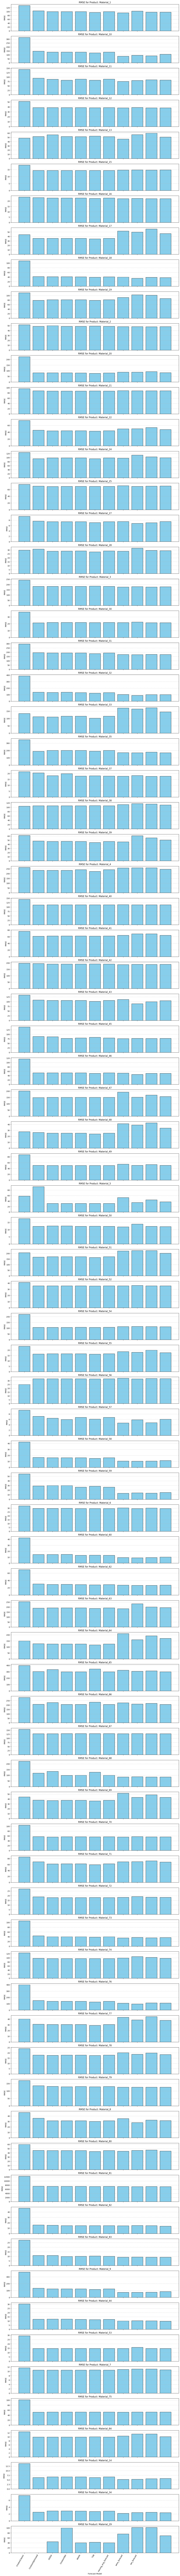

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Function to compute RMSE, MAE, and MAPE for each product
def calculate_metrics_per_product(test, forecasts_df):
    metrics_results = []

    # Merge actual test data with forecasts
    merged_df = test.merge(forecasts_df, on=["unique_id", "ds"], how="left")

    # Identify forecast models (excluding 'unique_id' and 'ds')
    forecast_columns = [col for col in forecasts_df.columns if col not in ["unique_id", "ds"]]

    # Compute metrics for each product
    for product in merged_df["unique_id"].unique():
        product_data = merged_df[merged_df["unique_id"] == product]

        for model in forecast_columns:
            valid_data = product_data[["y", model]].dropna()  # Remove NaN rows

            if not valid_data.empty:
                rmse = np.sqrt(mean_squared_error(valid_data["y"], valid_data[model]))
                mae = mean_absolute_error(valid_data["y"], valid_data[model])
                mape = np.mean(np.abs((valid_data["y"] - valid_data[model]) / valid_data["y"])) * 100  # Percentage

                metrics_results.append({"Product": product, "Model": model, "RMSE": rmse, "MAE": mae, "MAPE": mape})

    return pd.DataFrame(metrics_results)

# Compute metrics for all products
metrics_df = calculate_metrics_per_product(test, forecasts_df)

# Sort and display RMSE, MAE, MAPE tables
print("📊 RMSE Results (Lower is Better):")
print(metrics_df.sort_values(by="RMSE", ascending=True).head(10))  # Show top 10

print("\n📊 MAE Results (Lower is Better):")
print(metrics_df.sort_values(by="MAE", ascending=True).head(10))  # Show top 10

print("\n📊 MAPE Results (Lower is Better):")
print(metrics_df.sort_values(by="MAPE", ascending=True).head(10))  # Show top 10

# Plot RMSE separately for each product
unique_products = metrics_df["Product"].unique()
num_products = len(unique_products)

fig, axes = plt.subplots(nrows=num_products, figsize=(14, 4 * num_products), sharex=True)

if num_products == 1:
    axes = [axes]  # Ensure iterable if one product

for ax, product in zip(axes, unique_products):
    product_data = metrics_df[metrics_df["Product"] == product]

    ax.bar(product_data["Model"], product_data["RMSE"], color="skyblue", edgecolor="black")
    ax.set_title(f"RMSE for Product: {product}")
    ax.set_ylabel("RMSE")

    # Fix label issues
    ax.set_xticks(np.arange(len(product_data["Model"])))  # Ensure all models are plotted
    ax.set_xticklabels(product_data["Model"].tolist(), rotation=60, ha="right")  # Force all labels

    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.xlabel("Forecast Model")
plt.tight_layout(pad=2.5)
plt.subplots_adjust(bottom=0.4)  # Increase if needed
plt.show()


In [ ]:
best_models.to_csv('best_models_Stat.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from statsforecast.models import AutoETS, AutoTheta, CrostonClassic, SeasonalNaive, ADIDA, CrostonOptimized, CrostonSBA, IMAPA, TSB
from statsforecast.core import StatsForecast
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mase, mae, rmse
from typing import List
from functools import partial
from sklearn.metrics import mean_absolute_error, mean_squared_error
!pip install statsforecast
warnings.filterwarnings("ignore")

df = pd.read_csv('Customer Order Quantity_Dispatched Quantity_cleaned.csv')
weekly_df = df.groupby(['first_week_day', 'Product Name'])['Customer Order Quantity'].sum().reset_index()
weekly_df['first_week_day'] = pd.to_datetime(weekly_df['first_week_day'])
weekly_df = weekly_df.sort_values('first_week_day')
plt.figure(figsize=(12, 6))
plt.plot(weekly_df['first_week_day'], weekly_df['Customer Order Quantity'])
plt.xlabel('First Week Day')
plt.ylabel('Customer Order Quantity')
plt.title('Customer Order Quantity Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
weekly_df.columns = ["ds", "unique_id", "y"]
weekly_df["ds"] = pd.to_datetime(weekly_df["ds"])
#StatsForecast.plot(weekly_df) #commented out as it's not directly executable in this context
train = weekly_df[weekly_df.ds<='2024-06-30']
test = weekly_df[weekly_df.ds>'2024-06-30']
plt.figure(figsize=(12, 6))
sns.lineplot(train,x="ds", y="y", label="Train", linestyle="--",linewidth=2)
sns.lineplot(test, x="ds", y="y", label="Test", linewidth=2, color="orange")
plt.title("Customer Order");
plt.show()
season_length = 24
horizon = len(test['ds'].unique())
freq = "W-MON"
def moving_average_forecast(df, window=4, horizon=4):
    forecasts = []
    for uid in df["unique_id"].unique():
        series = df[df["unique_id"] == uid].sort_values("ds")
        past_values = series["y"].rolling(window=window).mean().iloc[-1] if len(series) >= window else series["y"].mean()
        future_dates = pd.date_range(start=series["ds"].max(), periods=horizon + 1, freq="W-MON")[1:]
        forecast_df = pd.DataFrame({"unique_id": uid, "ds": future_dates, "moving_avg_forecast": [past_values] * horizon})
        forecasts.append(forecast_df)
    return pd.concat(forecasts, ignore_index=True)
def weighted_moving_average_forecast(df, window=4, horizon=4):
    forecasts = []
    weights = np.arange(1, window + 1) / sum(np.arange(1, window + 1))
    for uid in df["unique_id"].unique():
        series = df[df["unique_id"] == uid].sort_values("ds")
        past_values = np.dot(series["y"].iloc[-window:], weights) if len(series) >= window else series["y"].mean()
        future_dates = pd.date_range(start=series["ds"].max(), periods=horizon + 1, freq="W-MON")[1:]
        forecast_df = pd.DataFrame({"unique_id": uid, "ds": future_dates, "wma_forecast": [past_values] * horizon})
        forecasts.append(forecast_df)
    return pd.concat(forecasts, ignore_index=True)
def exponential_smoothing_forecast(df, alpha=0.3, horizon=4):
    forecasts = []
    for uid in df["unique_id"].unique():
        series = df[df["unique_id"] == uid].sort_values("ds")["y"]
        ses_value = series.iloc[0] if len(series) > 1 else series.mean()
        for val in series:
            ses_value = alpha * val + (1 - alpha) * ses_value
        future_dates = pd.date_range(start=df[df["unique_id"] == uid]["ds"].max(), periods=horizon + 1, freq="W-MON")[1:]
        forecast_df = pd.DataFrame({"unique_id": uid, "ds": future_dates, "ses_forecast": [ses_value] * horizon})
        forecasts.append(forecast_df)
    return pd.concat(forecasts, ignore_index=True)
models = [SeasonalNaive(season_length=season_length),AutoTheta(season_length=season_length, decomposition_type="additive", model="STM"),CrostonClassic(),CrostonOptimized(),ADIDA(),CrostonSBA(),IMAPA(),TSB(alpha_d=0.5, alpha_p=0.5)]
sf = StatsForecast(models=models, freq=freq, fallback_model=SeasonalNaive(season_length=season_length), n_jobs=-1)
forecasts_df = sf.forecast(df=train, h=horizon)
moving_avg_df = moving_average_forecast(train, window=4, horizon=horizon)
wma_df = weighted_moving_average_forecast(train, window=4, horizon=horizon)
ses_df = exponential_smoothing_forecast(train, alpha=0.3, horizon=horizon)
forecasts_df = forecasts_df.merge(moving_avg_df, on=['unique_id', 'ds'], how='left')
forecasts_df = forecasts_df.merge(wma_df, on=['unique_id', 'ds'], how='left')
forecasts_df = forecasts_df.merge(ses_df, on=['unique_id', 'ds'], how='left')
forecasts_df.to_csv("statistical_full_data_forecast_with_MA_WMA_SES.csv", index=False)
agg_forecasts_df = forecasts_df.groupby('unique_id').mean()
print(agg_forecasts_df)
def calculate_rmse(test, forecasts_df):
    merged_df = pd.merge(test, forecasts_df, on=['unique_id', 'ds'])
    rmse_scores = []
    model_columns = [col for col in forecasts_df.columns if col not in ['unique_id', 'ds']]
    for model in model_columns:
        grouped_rmse = merged_df.groupby('unique_id').apply(lambda x: np.sqrt(np.mean((x['y'] - x[model])**2)))
        rmse_scores.append(pd.DataFrame({'unique_id': grouped_rmse.index, 'model': model, 'rmse': grouped_rmse.values}))
    return pd.concat(rmse_scores, ignore_index=True)
evaluation_df = calculate_rmse(test, forecasts_df)
evaluation_df['metric'] = 'rmse'
def select_best_model(metrics_df):
    return metrics_df.loc[metrics_df.groupby('unique_id')['rmse'].idxmin()][['unique_id', 'model', 'rmse']]
best_models = select_best_model(evaluation_df)
best_models.to_csv("best_forecasting_models.csv", index=False)
def calculate_metrics_per_product(test, forecasts_df):
    metrics_results = []
    merged_df = test.merge(forecasts_df, on=["unique_id", "ds"], how="left")
    forecast_columns = [col for col in forecasts_df.columns if col not in ["unique_id", "ds"]]
    for product in merged_df["unique_id"].unique():
        product_data = merged_df[merged_df["unique_id"] == product]
        for model in forecast_columns:
            valid_data = product_data[["y", model]].dropna()
            if not valid_data.empty:
                rmse = np.sqrt(mean_squared_error(valid_data["y"], valid_data[model]))
                mae = mean_absolute_error(valid_data["y"], valid_data[model])
                mape = np.mean(np.abs((valid_data["y"] - valid_data[model]) / valid_data["y"])) *